In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from pandas_datareader import data as pdr
from datetime import datetime, date, timedelta

# statistical analysis
import statsmodels.api as sm
from statsmodels import regression
import scipy.stats

import yfinance as yfin
yfin.pdr_override()
from var import VaR

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

#from var import VaR

pd.set_option('display.float_format', lambda x: f'{x:,.4f}')
sns.set_theme(rc={'axes.formatter.limits': (-8, 9)})
style.use('seaborn-whitegrid')
plt.rcParams["figure.figsize"] = (10,6)

# 0. Weekly Tasks
Prepare a presentation using Panopto (PowerPoint slides with Video Narration is an acceptable alternative) addressing the following points:
What scenario were you assigned as the result of the random number exercise?

- What were your considerations in determining an appropriate investment strategy for that scenario?

- What asset allocation did you implement that you felt best supported that investment strategy?

- What assets did you invest in consistent with that asset allocation and strategy? (Assets, Price at time of investment, % of total investment)

- Present Value, Profit/Loss to date, VaR, SHARPE, VWAP, Alpha (Other metrics that you feel important in support of your strategy) for your portfolio 

What reallocation of assets would you recommend at this time (if any) and why?
Post your presentation accessible to your colleagues for comment and comment on the presentations by your colleagues.

# 1. Variables

In [2]:
start_date = datetime(2022, 1, 1)
purchase_date = datetime(2023, 9, 11)
purchase_date_str = '2023-9-11'
end_date = datetime.now()
end_date_str = end_date.strftime("%Y-%m-%d")

alpha = 0.05
period = '5y'

# 2. Functions

# 3. Load Data

## 3.1 Load Variables

In [3]:
var_lst = ['^TNX']
data = pdr.get_data_yahoo(var_lst, start=start_date, end=end_date )['Close']
#rf_rate = round((data.mean() / 100),4)
rf_rate = round((data.mean()),4)
rf_rate

[*********************100%%**********************]  1 of 1 completed


3.348

In [4]:
var_lst = ['SPY']
bench_df = pdr.get_data_yahoo(var_lst, start=start_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_econ_df = pd.DataFrame(bench_df)
bench_econ_df.columns = ['SPY']

benchPercent_econ_df = bench_econ_df.pct_change()[1:]
benchPercent_econ_df.reset_index(inplace=True)
benchPercent_econ_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,SPY
0,2022-01-04,-0.0003
1,2022-01-05,-0.0192
2,2022-01-06,-0.0009
3,2022-01-07,-0.0040
4,2022-01-10,-0.0012


In [5]:
var_lst = ['FIBUX']
bench_df = pdr.get_data_yahoo(var_lst, start=start_date, end=end_date)['Close']
#bench_df = round((bench_df.mean() / 100),4)
bench_int_df = pd.DataFrame(bench_df)
bench_int_df.columns = ['FIBUX']

benchPercent_int_df = bench_int_df.pct_change()[1:]
benchPercent_int_df.reset_index(inplace=True)
benchPercent_int_df.head()

[*********************100%%**********************]  1 of 1 completed


,Date,FIBUX
0,2022-01-04,-0.0010
1,2022-01-05,-0.0029
2,2022-01-06,-0.0010
3,2022-01-07,-0.0029
4,2022-01-10,-0.0010


## 3.2 Load Portfolio

In [6]:
folio_df = pd.read_csv('https://raw.githubusercontent.com/dsimband/DATA618/main/w7/data/DATA618_Portfolio.csv', 
                 dtype={
                    'ID': 'int',
                    'Price': 'float',
                    'Shares': 'float',
                    'Value': 'float', 
                 })

folio_df = folio_df[folio_df['Shares'] > 0]
folio_df = folio_df.groupby(['Ticker','BondName','Class','Sub_Class'])[['Shares','Value']].sum()
folio_df.reset_index(inplace=True)

# calculate portfilio percentage
portfolio_total = folio_df['Value'].sum()
folio_df['port_percent'] = folio_df['Value'] / portfolio_total

# Class Portfolios
folio_econ_df = folio_df[folio_df['Class'] == 'Economically Sensitive']
folio_int_df = folio_df[folio_df['Class'] == 'Interest Rate Sensitive']

folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
...,...,...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,International Equities,"40,481.0000","3,000.0000",0.0360
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"40,221.0000","3,250.0000",0.0390
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,"9,234.0000","2,000.0000",0.0240
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,"41,501.0000","3,000.0000",0.0360


In [7]:
folio_df.groupby(['Class'])[['Value']].sum()

,Value
Class,
Cash,"4,183.0000"
Economically Sensitive,"50,250.0000"
Interest Rate Sensitive,"29,000.0000"


In [8]:
initial_investment = folio_df['Value'].sum() * 1000
initial_investment

83433000.0

# 4. Portfolio

## 4.1 Load Pricing Time Series

In [9]:
# ticker symbols
ticker_lst = list(folio_df['Ticker'])
print('ticker #:', len(ticker_lst))


# portfolio weights
weight_lst = (folio_df['port_percent'].values)
print('price #:', len(weight_lst))


#Download closing prices
price_df = pdr.get_data_yahoo(ticker_lst, start=start_date, end=end_date)['Close']

price_df['C_A_S_H'] = 1
print('price_df #:', price_df.shape)

#From the closing prices, calculate periodic returns
return_df = price_df.pct_change()
#return_df = return_df[1:]
return_df.fillna(0, inplace=True)
return_df.index = pd.to_datetime(return_df.index)
print('return_df #:', len(return_df.columns))

ticker #: 35
price #: 35
[*********************100%%**********************]  35 of 35 completed


1 Failed download:
['C_A_S_H']: Exception('%ticker%: No timezone found, symbol may be delisted')



price_df #: (448, 35)
return_df #: 35


## 4.2 Portfolio Returns

In [10]:
port_ret_weighted= return_df.mul(weight_lst, axis=1)
print('port_ret_weighted #:', port_ret_weighted.shape)

return_df['Portfolio'] = port_ret_weighted.sum(axis=1)
print('return_df #:', return_df.shape)

port_ret_weighted #: (448, 35)
return_df #: (448, 36)


In [11]:
weight_lst

array([0.01198567, 0.00599283, 0.00898925, 0.05013604, 0.02696775,
       0.03355986, 0.04794266, 0.00599283, 0.00599283, 0.01198567,
       0.06592116, 0.02397133, 0.04794266, 0.035957  , 0.04794266,
       0.04794266, 0.02996416, 0.01198567, 0.01198567, 0.01198567,
       0.05033979, 0.01198567, 0.01198567, 0.035957  , 0.01198567,
       0.07191399, 0.01198567, 0.06592116, 0.01198567, 0.02397133,
       0.035957  , 0.03895341, 0.02397133, 0.035957  , 0.01198567])

# 5. Calculate Portfolio Value

In [12]:
shares_df = folio_df[['Ticker','Shares']]
shares_df.set_index('Ticker', drop=True, inplace=True)
#shares_df[['Shares']].round(0)
shares_df.head()

,Shares
Ticker,
ALTVX,"106,383.0000"
BLUEX,"14,201.0000"
BPLSX,"49,967.0000"
C_A_S_H,"4,182,856.0000"
DFAR,"108,467.0000"


In [13]:
m_df = price_df.copy()
m_df.reset_index(inplace=True)
m_df = m_df.melt(id_vars=['Date'])
m_df.columns = ['Date','Ticker','Price']
m_df.head()

,Date,Ticker,Price
0,2022-01-03,ALTVX,10.7700
1,2022-01-04,ALTVX,10.7600
2,2022-01-05,ALTVX,10.7500
3,2022-01-06,ALTVX,10.7300
4,2022-01-07,ALTVX,10.7200


In [14]:
l_df = folio_df[['Ticker','Class','Sub_Class']] #.drop_duplicates() 
print('l_df: ',l_df.shape)

l_df:  (35, 3)


In [15]:
merge_df = m_df.merge(l_df, how='outer', left_on='Ticker', right_on='Ticker').merge(shares_df,how='outer' ,left_on='Ticker', right_on='Ticker')

merge_df['share_value'] = merge_df['Price'] * merge_df['Shares']
merge_df['perc_share_value'] = merge_df.groupby(['Ticker'])[['share_value']].pct_change()

print('merge_df: ',merge_df.shape)

merge_df:  (15680, 8)


In [16]:
merge_df

,Date,Ticker,Price,Class,Sub_Class,Shares,share_value,perc_share_value
0,2022-01-03,ALTVX,10.7700,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,145,744.9587",NaN
1,2022-01-04,ALTVX,10.7600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,144,681.1043",-0.0009
2,2022-01-05,ALTVX,10.7500,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,143,617.2500",-0.0009
3,2022-01-06,ALTVX,10.7300,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,141,489.5413",-0.0019
4,2022-01-07,ALTVX,10.7200,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,140,425.7884",-0.0009
...,...,...,...,...,...,...,...,...
15675,2023-10-09,VTEB,47.8100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","972,120.7579",0.0061
15676,2023-10-10,VTEB,47.8600,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","973,137.3924",0.0010
15677,2023-10-11,VTEB,48.2100,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","980,253.9114",0.0073
15678,2023-10-12,VTEB,48.1000,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"20,333.0000","978,017.2690",-0.0023


In [17]:
folioValue_df = merge_df.groupby(['Date'])[['share_value']].sum().reset_index()
folioValue_df['pct_change'] = folioValue_df['share_value'].pct_change()
#folioValue_df['pct_change'] = folioValue_df.groupby(['Class'])[['share_value']].pct_change()
#folioValue_df = folioValue_df[1:]

print('folioValue_df: ',folioValue_df.shape)

folioValue_df:  (448, 3)


In [18]:
fv_df = merge_df.groupby(['Date','Class'])[['share_value']].sum().reset_index()
#fv_df['pct_change'] = fv_df['share_value'].pct_change()
fv_df['pct_change'] = fv_df.groupby(['Class'])[['share_value']].pct_change()
#folioValue_df = folioValue_df[1:]

print('folioValue_df: ',fv_df.shape)

folioValue_df:  (1344, 4)


In [19]:
fv_df

,Date,Class,share_value,pct_change
0,2022-01-03,Cash,"4,182,856.0000",NaN
1,2022-01-03,Economically Sensitive,"53,337,534.7088",NaN
2,2022-01-03,Interest Rate Sensitive,"33,890,623.0734",NaN
3,2022-01-04,Cash,"4,182,856.0000",0.0000
4,2022-01-04,Economically Sensitive,"53,463,417.3560",0.0024
...,...,...,...,...
1339,2023-10-12,Economically Sensitive,"48,140,189.2998",-0.0107
1340,2023-10-12,Interest Rate Sensitive,"28,329,437.0559",-0.0059
1341,2023-10-13,Cash,"4,182,856.0000",0.0000
1342,2023-10-13,Economically Sensitive,"47,898,857.8304",-0.0050


## 5.1 Portfolio Value

In [20]:
folio_df

,Ticker,BondName,Class,Sub_Class,Shares,Value,port_percent
0,ALTVX,AB Municipal Income National Advisor,Interest Rate Sensitive,Very-High-Quality Municipal Bonds,"106,383.0000","1,000.0000",0.0120
1,BLUEX,AMG Veritas Global Real Return I,Economically Sensitive,Long/Short Equities,"14,201.0000",500.0000,0.0060
2,BPLSX,Boston Partners Long/Short Equity Instl,Economically Sensitive,Long/Short Equities,"49,967.0000",750.0000,0.0090
3,C_A_S_H,Cash,Cash,Cash,"4,182,856.0000","4,183.0000",0.0501
4,DFAR,Dimensional US Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"108,467.0000","2,250.0000",0.0270
...,...,...,...,...,...,...,...
30,VIGI,Vanguard Intl Div Apprec ETF,Economically Sensitive,International Equities,"40,481.0000","3,000.0000",0.0360
31,VNQ,Vanguard Real Estate ETF,Economically Sensitive,Publicly Traded REITs,"40,221.0000","3,250.0000",0.0390
32,VO,Vanguard Mid-Cap ETF,Economically Sensitive,U.S. Equities,"9,234.0000","2,000.0000",0.0240
33,VONG,Vanguard Russell 1000 Growth ETF,Economically Sensitive,U.S. Equities,"41,501.0000","3,000.0000",0.0360


In [21]:
folio_df.groupby(['Class','Sub_Class'])[['Value']].sum()

Value
Class                   Sub_Class                                    
Cash                    Cash                               4,183.0000
Economically Sensitive  Emerging Market Equities           4,000.0000
                        International Equities             8,000.0000
                        Long/Short Equities                2,250.0000
                        Private Equity                     4,200.0000
                        Publicly Traded REITs             10,800.0000
                        U.S. Equities                     21,000.0000
Interest Rate Sensitive U.S. Government Bonds             17,000.0000
                        Very-High-Quality Corporate Bonds  6,000.0000
                        Very-High-Quality Municipal Bonds  6,000.0000

In [22]:
folio_df[['Value']].sum()

Value   83,433.0000
dtype: float64

In [23]:
round(merge_df[merge_df['Date'] == purchase_date_str].groupby(['Class','Sub_Class'])[['share_value']].sum(),0)

share_value
Class                   Sub_Class                                        
Cash                    Cash                               4,182,856.0000
Economically Sensitive  Emerging Market Equities           4,064,746.0000
                        International Equities             8,021,974.0000
                        Long/Short Equities                2,250,024.0000
                        Private Equity                     4,200,007.0000
                        Publicly Traded REITs             10,900,988.0000
                        U.S. Equities                     21,098,135.0000
Interest Rate Sensitive U.S. Government Bonds             16,999,996.0000
                        Very-High-Quality Corporate Bonds  6,000,003.0000
                        Very-High-Quality Municipal Bonds  5,999,956.0000

In [24]:
round(merge_df[merge_df['Date'] == purchase_date_str][['share_value']].sum(),0)

share_value   83,718,684.0000
dtype: float64

In [25]:
folioValue_df[folioValue_df['Date'] == purchase_date_str]

,Date,share_value,pct_change
423,2023-09-11,"83,718,683.5760",0.0024


In [26]:
round(merge_df[merge_df['Date'] == end_date_str].groupby(['Class','Sub_Class'])[['share_value']].sum(),0)

,,share_value
Class,Sub_Class,


In [27]:
round(merge_df[merge_df['Date'] == end_date_str][['share_value']].sum(),0)

share_value   0.0000
dtype: float64

In [28]:
folioValue_df[folioValue_df['Date'] == end_date_str]

,Date,share_value,pct_change


# 6. Correlation

In [29]:
benchPercent_econ_df

,Date,SPY
0,2022-01-04,-0.0003
1,2022-01-05,-0.0192
2,2022-01-06,-0.0009
3,2022-01-07,-0.0040
4,2022-01-10,-0.0012
...,...,...
442,2023-10-09,0.0064
443,2023-10-10,0.0052
444,2023-10-11,0.0041
445,2023-10-12,-0.0061


In [30]:
m_df = merge_df.groupby(['Date','Class'])[['share_value']].sum()
#m_df.reset_index(inplace=True)
m_df['pct_change'] = m_df.groupby(['Class'])[['share_value']].pct_change()
#m_df = m_df.pivot(index=['Date','Class'], columns=['share_value','pct_change'])
m_df.reset_index(inplace=True)
#m_df = m_df.pivot(index=['Date'], columns=['Class'])[['share_value','pct_change']]
m_df = m_df.pivot(index=['Date'], columns=['Class'])['pct_change']
m_df

Class,Cash,Economically Sensitive,Interest Rate Sensitive
Date,,,
2022-01-03,NaN,NaN,NaN
2022-01-04,0.0000,0.0024,-0.0011
2022-01-05,0.0000,-0.0185,-0.0029
2022-01-06,0.0000,-0.0001,-0.0025
2022-01-07,0.0000,-0.0015,-0.0016
...,...,...,...
2023-10-09,0.0000,0.0057,0.0072
2023-10-10,0.0000,0.0073,0.0004
2023-10-11,0.0000,0.0064,0.0048


In [31]:
p_df = m_df.merge(benchPercent_econ_df, how='outer', left_on='Date', right_on='Date') \
            .merge(benchPercent_int_df,how='outer' ,left_on='Date', right_on='Date')
p_df.drop(labels=['Date','Cash'], inplace=True, axis=1)
p_df.columns = ['Economic','Interest','SPY','FHNFX']
p_df

,Economic,Interest,SPY,FHNFX
0,NaN,NaN,NaN,NaN
1,0.0024,-0.0011,-0.0003,-0.0010
2,-0.0185,-0.0029,-0.0192,-0.0029
3,-0.0001,-0.0025,-0.0009,-0.0010
4,-0.0015,-0.0016,-0.0040,-0.0029
...,...,...,...,...
443,0.0057,0.0072,0.0064,0.0093
444,0.0073,0.0004,0.0052,0.0000
445,0.0064,0.0048,0.0041,0.0046
446,-0.0107,-0.0059,-0.0061,-0.0092


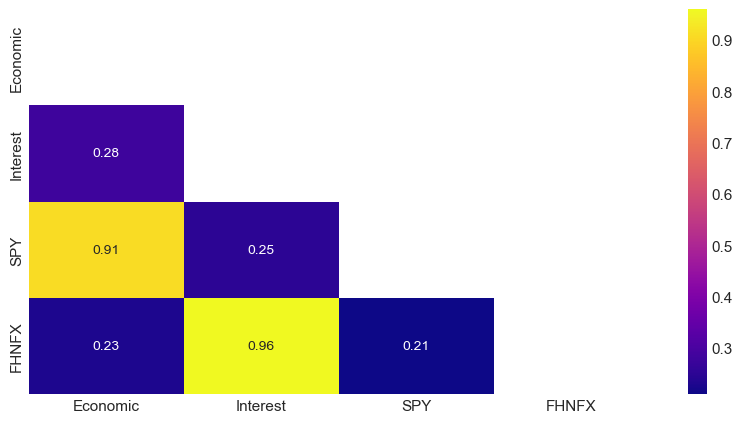

In [32]:
plt.figure(figsize=(10,5))
mask = np.zeros_like(p_df.corr())
mask[np.triu_indices_from(mask)] = True
sns.set_style("white")
_p = sns.heatmap(p_df.corr().round(2), 
                 annot=True, mask=mask, 
                 cmap="plasma", annot_kws={"size": 10})

# 7. Value at Risk

## 7.1 Load Historic Variables

## 7.2 Load Historic Values

# 8. Calculate VaR

In [33]:
#weights = folio_df['port_percent'].values
#print('weight', len(weights))

r_df = return_df.drop(labels='Portfolio', axis=1)[1:]
print('r_df', r_df.shape)

r_df (447, 35)


In [34]:
r_df

,ALTVX,BLUEX,BPLSX,C_A_S_H,DFAR,FREL,FSMD,...,VGCAX,VICSX,VIGI,VNQ,VO,VONG,VTEB
Date,,,,,,,,,,,,,,,
2022-01-04,-0.0009,-0.0034,0.0189,0.0000,0.0000,0.0000,0.0089,...,-0.0009,0.0000,-0.0025,-0.0012,-0.0007,-0.0107,0.0000
2022-01-05,-0.0009,-0.0086,0.0033,0.0000,0.0000,-0.0287,-0.0218,...,-0.0019,-0.0032,-0.0138,-0.0286,-0.0250,-0.0319,-0.0013
2022-01-06,-0.0019,-0.0005,0.0060,0.0000,0.0000,0.0006,0.0062,...,-0.0019,-0.0028,-0.0070,0.0009,0.0026,-0.0021,-0.0011
2022-01-07,-0.0009,0.0015,0.0013,0.0000,0.0000,-0.0063,-0.0065,...,-0.0019,-0.0024,0.0012,-0.0066,-0.0060,-0.0110,-0.0024
2022-01-10,-0.0028,0.0047,0.0007,0.0000,0.0000,-0.0066,-0.0028,...,-0.0009,-0.0016,-0.0087,-0.0058,-0.0033,-0.0008,-0.0020
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-09,0.0022,0.0038,0.0060,0.0000,0.0136,0.0121,0.0069,...,0.0073,0.0099,0.0025,0.0109,0.0079,0.0050,0.0061
2023-10-10,0.0033,0.0032,0.0007,0.0000,0.0021,0.0049,0.0077,...,0.0011,0.0010,0.0103,0.0048,0.0079,0.0043,0.0010
2023-10-11,0.0077,0.0044,0.0033,0.0000,0.0195,0.0172,0.0003,...,0.0039,0.0039,0.0087,0.0174,0.0028,0.0082,0.0073


In [35]:
l2 = list(folio_df['Ticker'])
l1 = r_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  35 l2:  35 dif:  set()


In [36]:
var = VaR(r_df, weight_lst, alpha=[0.05,0.025,0.01])
#var = VaR(percent_df, weights, alpha=0.05)
var

<VaR - μ: -0.04%, σ: 0.7193%, Portfolio σ: 0.7201%>

In [37]:
var.info

{'Daily Mean PnL': -0.0003617912683639436,
 'Daily Volatility': 0.007193050177070204,
 'Portfolio Volatility': 0.007201109619572561}

In [38]:
var.historic()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0124,-0.0149,-0.0180,-0.0159,-0.0183,-0.0217,-0.1902,-0.1966,-0.1996


In [39]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.235730079206769
Portfolio VaR(95.0) -1031006.6769845835


In [40]:
var.parametric()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0241,-0.0254,-0.0271,-0.0290,-0.0290,-0.0290,-0.1902,-0.1966,-0.1996


In [41]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -2.405723496797088
Portfolio VaR(95.0) -2007167.2850827144


In [42]:
var.monte_carlo()

,VaR(95.0),VaR(97.5),VaR(99.0),CVaR(95.0),CVaR(97.5),CVaR(99.0),CDaR(95.0),CDaR(97.5),CDaR(99.0)
2023-10-13,-0.0122,-0.0145,-0.0171,-0.0153,-0.0172,-0.0196,-0.1902,-0.1966,-0.1996


In [43]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.2215561613415775
Portfolio VaR(95.0) -1023950.1244619063


In [44]:
#var.monte_carlo(stressed=True)

In [45]:
l2 = list(folio_df['Ticker'])
l1 = r_df.columns
list_dif = set(l2).symmetric_difference(set(l1))


print('l1: ', len(l1), 'l2: ', len(l2), 'dif: ', list_dif)

l1:  35 l2:  35 dif:  set()


In [56]:
var = VaR(r_df, weight_lst, alpha=[0.05,0.025,0.01])
#var = VaR(r_df, weight_lst, alpha=0.05)
var

<VaR - μ: -0.04%, σ: 0.7193%, Portfolio σ: 0.7201%>

In [47]:
var.info

{'Daily Mean PnL': -0.0003617912683639436,
 'Daily Volatility': 0.007193050177070204,
 'Portfolio Volatility': 0.007201109619572561}

In [48]:
var.historic()

,VaR(95.0),CVaR(95.0),CDaR(95.0)
2023-10-13,-0.0124,-0.0159,-0.1902


In [49]:
print('VaR(95.0):', var.historic()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.historic()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.235730079206769
Portfolio VaR(95.0) -1031006.6769845835


In [50]:
var.parametric()

,VaR(95.0),CVaR(95.0),CDaR(95.0)
2023-10-13,-0.0241,-0.0290,-0.1902


In [51]:
print('VaR(95.0):', var.parametric()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.parametric()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -2.405723496797088
Portfolio VaR(95.0) -2007167.2850827144


In [52]:
var.monte_carlo()

,VaR(95.0),CVaR(95.0),CDaR(95.0)
2023-10-13,-0.0122,-0.0152,-0.1902


In [53]:
print('VaR(95.0):', var.monte_carlo()['VaR(95.0)'][0]*100)
print('Portfolio VaR(95.0)', var.monte_carlo()['VaR(95.0)'][0]*portfolio_total*1000)

VaR(95.0): -1.2101731378046734
Portfolio VaR(95.0) -1017843.421002818


In [54]:
var.monte_carlo(stressed=True)

,VaR(95.0),CVaR(95.0),CDaR(95.0)
2023-10-13,-0.0182,-0.0200,-0.5142


# Backtest

In [58]:
bth = var.backtest(method='h')

Backtest: Historic Method: 100%|██████████| 197/197 [00:00<00:00, 2756.51it/s]


In [59]:
var.evaluate(bth)

,Amount,Percent,Mean Deviation,STD Deviation,Min Deviation,Max Deviation
Observations,197,1,0,0,0,0
VaR(95.0),2,0.0102,-0.0019,0.0008,-0.0011,-0.0027
VaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CVaR(95.0),1,0.0051,-0.0004,0.0000,-0.0004,-0.0004
CVaR(99.0),0,0.0000,NaN,NaN,NaN,NaN
CDaR(95.0),0,0.0000,0,0,0,0
CDaR(99.0),0,0.0000,0,0,0,0


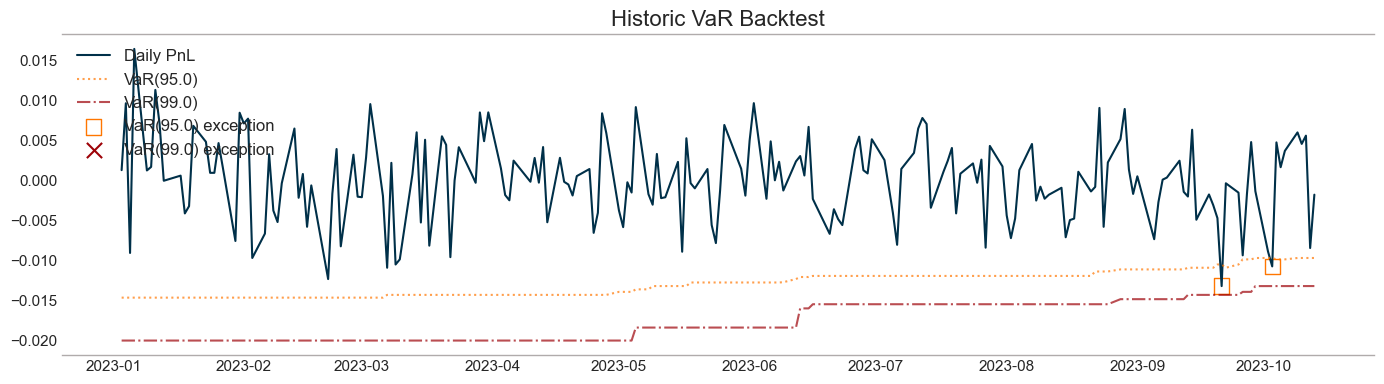

In [60]:
var.var_plot(bth)

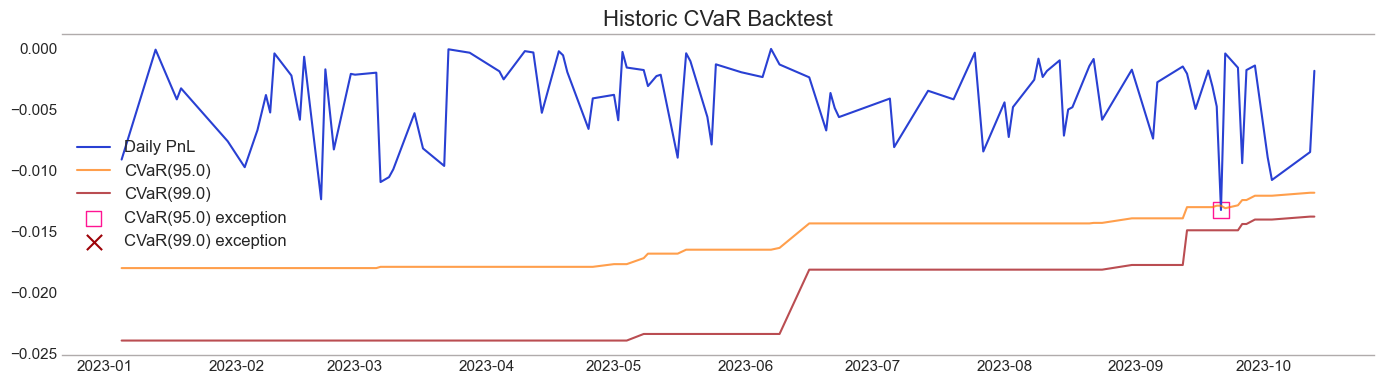

In [61]:
var.cvar_plot(bth)

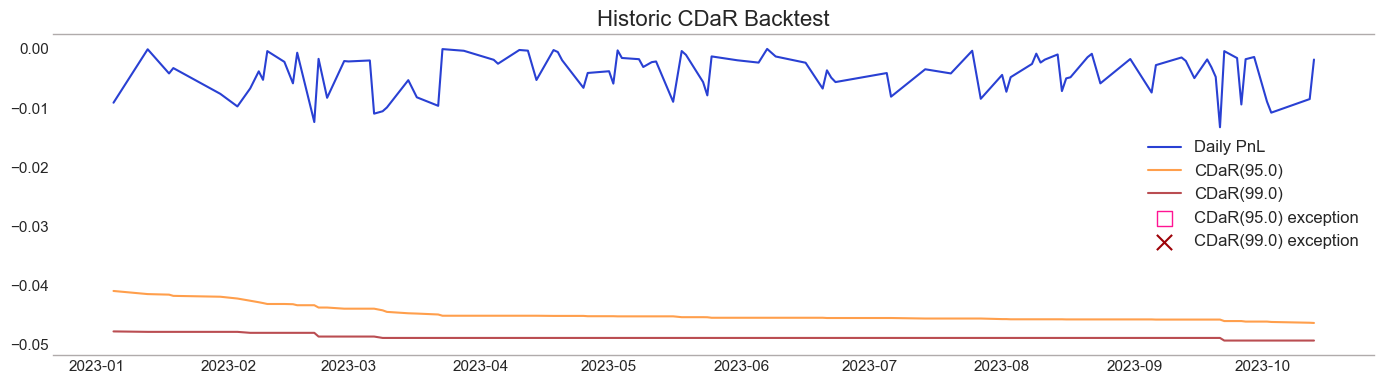

In [62]:
var.cdar_plot(bth)